In [1]:
from PIL import Image
import PIL
import numpy as np
from resizeimage import resizeimage
import numpy as np
import scipy.stats as st
from math import pi,exp

In [2]:
sample=Image.open('fox.jpg')

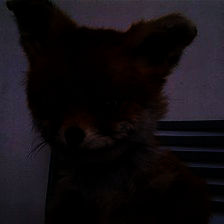

In [28]:
Correction(sample,mode='power',gamma=5)

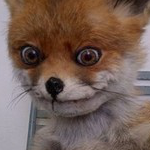

In [184]:
Crop(sample,20,50,150,150)

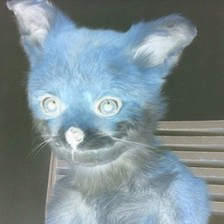

In [185]:
ColorFilter(sample,mode='negative')

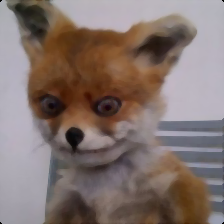

In [35]:
CustomFilter(sample,5,mode='median',sigma=2)

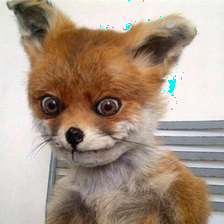

In [210]:
WhiteBalance(sample,mode='white')

In [33]:
def Correction(img,mode='linear',gamma=0.5):
    r,g,b=map(lambda x:np.array(x,dtype='float')/255,img.split())
    if mode=='linear':
        r,g,b=map(lambda p: ApplyCorrection(p,mode='linear'),(r,g,b))
        img=PilFromRGB(r,g,b)
        return img
    if mode=='power':
        r,g,b=map(lambda p: ApplyCorrection(p,mode='power',gamma=gamma),(r,g,b))
        img=PilFromRGB(r,g,b)
        return img
        
def ApplyCorrection(img,mode='linear',gamma=0.5):
    if mode=='linear':
        max_v=img.max()
        min_v=img.min()
        for i in np.nditer(img,op_flags=['readwrite']):
            i[...]=((i-min_v)/(max_v-min_v))
        return img*255
    if mode=='power':
        img=img**gamma
        return img*255

def Crop(img,left,top,width,hight):
    r,g,b=map(np.array,img.split())
    r,g,b=map(lambda p:ApplyCrop(p,left,top,width,hight),(r,g,b))
    return PilFromRGB(r,g,b)
def ApplyCrop(img,left,top,width,hight):
    return img[top:(top+hight),left:(left+width)]


def CustomFilter(img,filter_size,mode='box',sigma=None):
    #my_filter=np.zeros((filter_size,filter_size))
    r,g,b=map(lambda x:np.array(x,dtype='float'),img.split())
    r,g,b=map(lambda x:AddBorders(x,filter_size),(r,g,b))
    if mode=='box':
        r,g,b=map(lambda x:ApplyCustomFilter(x,filter_size,mode='box'),(r,g,b))
    if mode=='gaus':
        r,g,b=map(lambda x:ApplyCustomFilter(x,filter_size,mode='gaus',sigma=sigma),(r,g,b))
    if mode=='median':
        r,g,b=map(lambda x:ApplyCustomFilter(x,filter_size,mode='median'),(r,g,b))
    return PilFromRGB(r,g,b)
def ApplyCustomFilter(img,filter_size,mode='box',sigma=None):
    border=(filter_size-1)/2
    new_img=np.zeros((img.shape[0]-border*2,img.shape[1]-border*2))
    if mode=='box':
        myfilter=np.ones((filter_size,filter_size))/(filter_size**2)
        for i in range(new_img.shape[0]):
            for j in range(new_img.shape[1]):
                new_img[i][j]=np.multiply(img[i:i+filter_size,j:j+filter_size],myfilter).sum()
    if mode=='gaus':
        myfilter=gkern(filter_size,sigma)
        for i in range(new_img.shape[0]):
            for j in range(new_img.shape[1]):
                new_img[i][j]=np.multiply(img[i:i+filter_size,j:j+filter_size],myfilter).sum()
    if mode=='median':
        for i in range(new_img.shape[0]):
            for j in range(new_img.shape[1]):
                new_img[i][j]=np.median(img[i:i+filter_size,j:j+filter_size])      
    return new_img


def ColorFilter(img,mode='monochrome'):
    r,g,b=map(lambda x:np.array(x,dtype='float')/255,img.split())
    rgb=np.stack((r,g,b))
    new_img=np.zeros_like(rgb)
    if mode=='monochrome':
        matrix=[[0.2125,0.7154,0.0721],
                [0.2125,0.7154,0.0721],
                [0.2125,0.7154,0.0721]]
        new_img=ApplyColorFilter(rgb,matrix)
        if np.array_equal(new_img[0,::],new_img[1,::]):
            new_img=(new_img*255).astype('uint8')
            return Image.fromarray(new_img[0,::],mode='L')
        else:
            print('Error monochrome')
            return -1
    if mode=='negative':
        matrix=[[-1,0,0],
                [0,-1,0],
                [0,0,-1]] 
        new_img=ApplyColorFilter(rgb,matrix)
        new_img=((new_img+1)*255).astype('uint8')
        return PilFromRGB(new_img[0],new_img[1],new_img[2])
def ApplyColorFilter(img,matrix):
    new_img=np.zeros_like(img)
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            new_img[:,i,j]=np.dot(matrix,img[:,i,j])
    return new_img


def WhiteBalance(img,mode='white'):
    r,g,b=map(lambda x:np.array(x,dtype='float'),img.split())
    Average=(r+g+b).mean()/3
    if mode=='white':
        rgb=np.stack((r,g,b))
        max_pixel=np.unravel_index(np.argmax(np.sum(rgb,axis=0)), r.shape)
        r,g,b=map(lambda x: x*255/x[max_pixel],(r,g,b))
    if mode=='grey':
        r,g,b=map(lambda x:x*Average/x.mean(),(r,g,b))
    return PilFromRGB(r,g,b)


def AddBorders(img,filter_size):
    border_size=(filter_size-1)/2
    temp=np.zeros((img.shape[0]+2*(border_size),img.shape[1]+2*(border_size)))
    temp[border_size:-border_size,border_size:-border_size]=img
    return temp
def PilFromRGB(r,g,b):
    rgbArray = np.zeros((r.shape[0],r.shape[1],3), 'uint8')
    rgbArray[..., 0] = r
    rgbArray[..., 1] = g
    rgbArray[..., 2] = b
    return Image.fromarray(rgbArray)
def gkern(l=5, sig=1.):
    
    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel / np.sum(kernel)

In [40]:
l=5
ax = np.arange(-l // 2 + 1., l // 2 + 1.)
xx, yy = np.meshgrid(ax, ax)

In [41]:
xx

array([[-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.]])

In [245]:
#r,g,b=map(lambda x:np.array(x,dtype='float')/255,sample.split())
r,g,b=map(lambda x:np.array(x),sample.split())

In [251]:
r=AddBorders(r[:6][:6],5)


In [32]:
np.median(gkern(5,1))

0.021938231279714643

In [248]:
g=np.zeros((6,6))

In [253]:
for i in range(6):
    for j in range(6):
        g[i][j]=np.multiply(r[i:i+5,j:j+5],b).mean()

In [254]:
g

array([[ 0.02066436,  0.11315682,  0.26567094,  0.35852633,  0.37939956,
         0.37902573],
       [ 0.11256301,  0.61685947,  1.44975829,  1.95907932,  2.07503503,
         2.07351805],
       [ 0.26277218,  1.4407983 ,  3.38793627,  4.57964361,  4.8496179 ,
         4.8453465 ],
       [ 0.35307419,  1.93570901,  4.54830029,  6.13702168,  6.48450082,
         6.47312912],
       [ 0.3543189 ,  1.94004695,  4.54697206,  6.10945132,  6.43230561,
         6.41211467],
       [ 0.26349804,  1.44141883,  3.37287767,  4.52272852,  4.75951762,
         4.74292145]])

In [30]:
r[:3,:3]

array([[   0.,    0.,    0.],
       [   0.,  174.,  173.],
       [   0.,  168.,  171.]])

In [32]:
np.multiply(r[:3,:3],np.ones((3,3))).sum()

686.0

In [398]:
rgb=np.stack((r,g,b))

In [385]:
for i in range(rgb.shape[1]):
    for j in range(rgb.shape[2]):
        temp[:,i,j]=np.dot(matrix,rgb[:,i,j])
temp=((temp+1)*255).astype('uint8')

In [386]:
temp[0]

array([[ 81,  81,  79, ...,  71,  71,  71],
       [ 87,  84,  81, ...,  73,  73,  73],
       [ 81,  84,  87, ...,  74,  73,  73],
       ..., 
       [101, 100,  98, ..., 105, 105, 105],
       [102, 101, 100, ..., 104, 105, 105],
       [102, 102, 101, ..., 104, 105, 106]], dtype=uint8)

In [361]:
temp[0]

array([[174, 173, 176, ..., 184, 184, 184],
       [168, 171, 174, ..., 181, 182, 182],
       [174, 171, 168, ..., 180, 181, 182],
       ..., 
       [154, 155, 156, ..., 150, 149, 149],
       [153, 154, 155, ..., 151, 149, 149],
       [153, 153, 154, ..., 151, 149, 148]], dtype=uint8)

In [324]:
temp=temp.reshape((224,224,3))

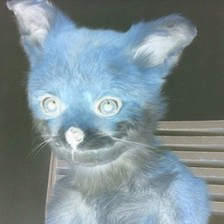

In [394]:
Image.fromarray(np.dstack((temp[0],temp[1],temp[2])))

In [236]:
Image.fromarray(temp[0,::],mode='L')

In [ ]:
res[0]

In [120]:
np.zeros((r.shape[0]+2*(2-1),r.shape[1]+2*(2-1)))

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [363]:
# matrix=np.array([[0.2125,0.7154,0.0721],
#         [0.2125,0.7154,0.0721],
#         [0.2125,0.7154,0.0721]],dtype='float')
matrix=[[-1,0,0],
        [0,-1,0],
        [0,0,-1]] 

In [184]:
r=np.random.rand(5,5,3)

In [195]:
r[0,0,:]

array([ 1.,  1.,  1.,  1.,  1.])

In [180]:
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        g[i][j]=np.dot(matrix,r[i][j])*255

In [171]:
matrix

array([[ 0.2125,  0.7154,  0.0721],
       [ 0.2125,  0.7154,  0.0721],
       [ 0.2125,  0.7154,  0.0721]])

In [204]:
rgb=np.array(sample,dtype='float')/255

In [176]:
g=np.zeros_like(r)

In [191]:
r=np.ones((5,3,5),dtype='float')